In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
from datetime import date

pd.options.display.max_columns = 40
pd.options.mode.chained_assignment = None  # default='warn'

## Hack for Heat #8: Complaint resolution time revisited

In this post, I'm going to explore a simple way of dealing with the censoring issue in complaint resolution time: Basically, because we only care about heat complaints during the heat season, we can constrain our cases of interest to the heating season specifically (1<sup>st</sup> October to May 31<sup>st</sup>).

In [2]:
#pull from our database again:
connection = psycopg2.connect('dbname = threeoneone user= threeoneoneadmin password = threeoneoneadmin')

In [3]:
cursor = connection.cursor()

In [4]:
cursor.execute('''SELECT createddate, closeddate, borough, complainttype FROM service;''')

In [5]:
data = cursor.fetchall()

In [6]:
data = pd.DataFrame(data)

In [7]:
data.columns = ['createddate', 'closeddate', 'borough', 'complainttype']

In [8]:
data = data.loc[(data['complainttype'] == 'HEATING') | (data['complainttype'] == 'HEAT/HOT WATER') ]

So far, we've subsetted the data to only include the heating complaints. Now let's create a datetime mask. What we want is to have subsets of data for each of the heating seasons:

In [9]:
heatmonths = range(1, 6) + [10,11,12]

In [10]:
heatmonths

[1, 2, 3, 4, 5, 10, 11, 12]

In [11]:
createdmask = data['createddate'].map(lambda x: (x.month in heatmonths))
closedmask = data['closeddate'].map(lambda x: (x.month in heatmonths) if x != None else False)

In [12]:
mask = createdmask & closedmask

In [13]:
heatseasondata = data.loc[mask]

How many heat/hot water complaints are created and closed inside vs. outside of heating season?

In [14]:
len(data.loc[mask]) #inside heating season

1302688

In [15]:
len(data.loc[~mask])#outside heating season

68750

The next thing we want to do is ignore cases where the complaint was resolved in the *next* heating season:

In [16]:
prevmonths = range(1, 6) 
nextmonths = [10,11,12]

In [17]:
heatseasondata['createdheatseason'] = [x.year if (x.month in prevmonths) else (x.year-1) for x in heatseasondata['createddate']]

In [18]:
heatseasondata.head()

,createddate,closeddate,borough,complainttype,createdheatseason
0,2014-11-18,2014-11-22,BROOKLYN,HEAT/HOT WATER,2013
1,2014-11-18,2014-11-25,BROOKLYN,HEAT/HOT WATER,2013
2,2014-11-18,2014-11-19,BRONX,HEAT/HOT WATER,2013
3,2014-11-18,2014-11-19,MANHATTAN,HEAT/HOT WATER,2013
4,2014-11-18,2014-11-20,BRONX,HEAT/HOT WATER,2013


In [19]:
heatseasondata['closedheatseason'] = [x.year if (x.month in prevmonths) else (x.year-1) for x in heatseasondata['closeddate']]

Now that we've done this, we can select only the cases where the closed date was in the same season as the created date:

In [20]:
heatseasondata = heatseasondata.loc[heatseasondata['createdheatseason']  == heatseasondata['closedheatseason']]

Okay, now we can calculate some average resolution times:

In [21]:
heatseasondata['resolutiontime'] = heatseasondata['closeddate'] - heatseasondata['createddate']

In [22]:
heatseasondata['resolutiontimeint'] = heatseasondata.resolutiontime.astype('timedelta64[D]')

In [23]:
resolutiontimedata = heatseasondata.groupby(by='createdheatseason').mean()['resolutiontimeint']

In [24]:
resolutiontimedata.to_csv('resolutiontimebyyear.csv')

In [25]:
resolutiontimedata

createdheatseason
2009    4.605845
2010    3.695498
2011    3.666409
2012    3.623974
2013    3.514244
2014    3.137578
2015    3.406145
2016    3.446075
Name: resolutiontimeint, dtype: float64


## Resolution times by year:

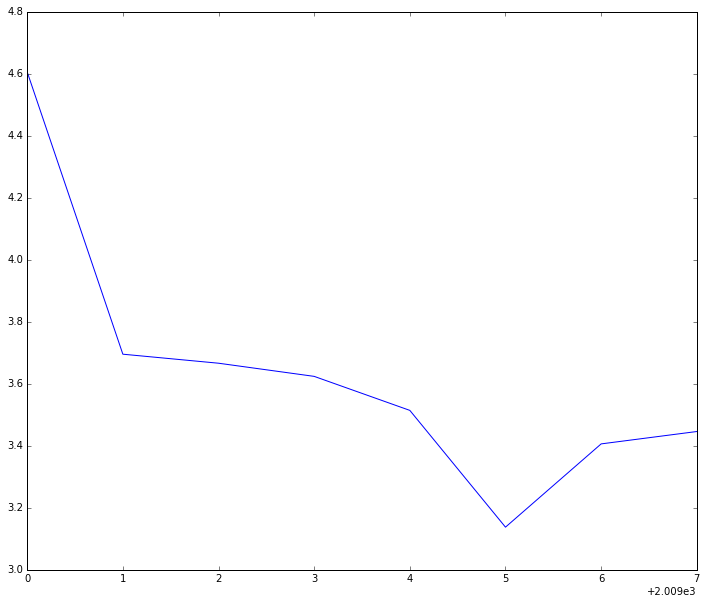

In [26]:
x = resolutiontimedata.index.values
y = resolutiontimedata.values

plt.figure(figsize=(12,10));
plt.plot(x,y);

## Resolution time by borough:

In [27]:
restimebyboro = heatseasondata.groupby(by=['borough', 'createdheatseason']).mean()['resolutiontimeint']

In [28]:
restimebyboro.to_csv('restimebyboro.csv')

In [29]:
restimebyboro = restimebyboro.loc[[x in range(2010,2017) for x in restimebyboro.index.get_level_values('createdheatseason')]]

In [31]:
boros = heatseasondata.borough.unique()

In [32]:
boroplots = {x:[] for x in boros}
for boro in boros:
    boroplots[boro] = restimebyboro.xs(boro).values
    
boroplots.pop('Unspecified')

array([ 3.64268956,  3.89000015])

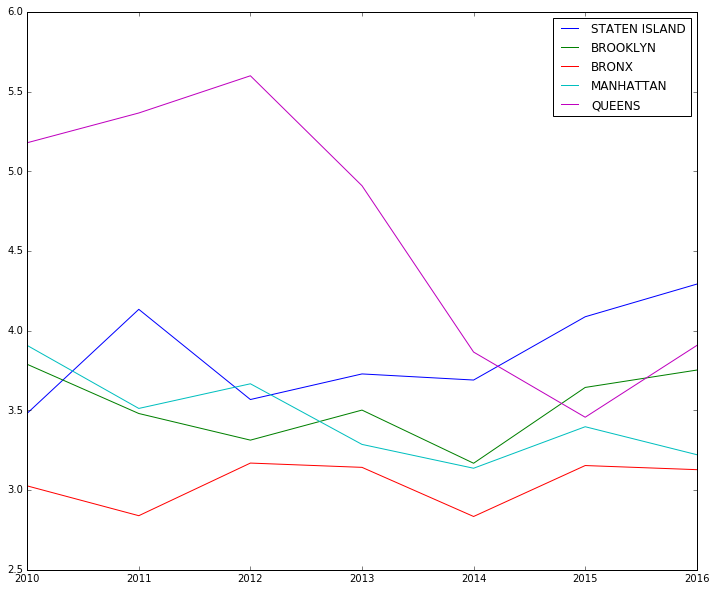

In [33]:
x = range(2010,2017)

plt.figure(figsize=(12,10));
for boro in boroplots:
    plt.plot(x,boroplots[boro]);
plt.legend(boroplots.keys());
plt.xticks(x, [str(label) for label in x]);

I was told beforehand that the average resolution time from a similar analysis last year was about 3-5 days, so this looks about right.